# Simulation Experiments

In [1]:
import sys
sys.path.append('..')
sys.path.append('../src')

import opendatasets as od
import tempfile
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from src.crepes_weighted import WrapRegressor
import copy
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def weighted_sample(weights, frac=0.5):
    return np.random.choice(range(len(weights)), size=int(len(weights) * frac), p=weights)

## Airfoil Dataset

In [3]:
with tempfile.TemporaryDirectory() as temp_dir:
    od.download("https://archive.ics.uci.edu/static/public/291/airfoil+self+noise.zip",
                temp_dir)
    with zipfile.ZipFile(temp_dir + "/airfoil+self+noise.zip", 'r') as zip_ref:
        df = pd.read_csv(zip_ref.open('airfoil_self_noise.dat'), sep='\t', header=None)
        df.columns = ['Frequency', 'Angle', 'Chord', 'Velocity', 'Suction', 'Sound']
        df['Log_freq'] = np.log(df['Frequency'])
        df['Log_suct'] = np.log(df['Suction'])
        df = df.drop(columns=['Frequency', 'Suction'])

65536it [00:00, 81994.32it/s] 


In [4]:
NSim = 1000
confidence = 0.8

for i in tqdm(range(NSim)):
    # Without covariate-shift
    X_train, X_test, y_train, y_test = train_test_split(df.drop('Sound', axis=1), df['Sound'], test_size=0.5)
    X_train_prop, X_cal, y_train_prop, y_cal = train_test_split(X_train, y_train, test_size=0.5)

    shifted_likelihood_train_prop = np.exp(X_train_prop[['Log_freq', 'Log_suct']].to_numpy() @ np.array([-1, 1]))
    shifted_weights_train_prop = shifted_likelihood_train_prop / np.sum(shifted_likelihood_train_prop)
    shifted_likelihood_test = np.exp(X_test[['Log_freq', 'Log_suct']].to_numpy() @ np.array([-1, 1]))
    shifted_weights_test = shifted_likelihood_test / np.sum(shifted_likelihood_test)
    shifted_likelihood_cal = np.exp(X_cal[['Log_freq', 'Log_suct']].to_numpy() @ np.array([-1, 1]))

    rf_cps = WrapRegressor(RandomForestRegressor(n_estimators=100, random_state=17))
    rf_cps.fit(X_train_prop, y_train_prop)
    rf_cp = copy.deepcopy(rf_cps)
    rf_cp.calibrate(X_cal, y_cal, cps=False)
    rf_cps.calibrate(X_cal, y_cal, cps=True)

    idx_no_shift = weighted_sample(np.ones(len(shifted_weights_test))/len(shifted_weights_test), frac=0.25)
    idx_shift = weighted_sample(shifted_weights_test, frac=0.25)

    n_reduced = np.sum(np.abs(shifted_likelihood_cal))**2 / np.sum(shifted_likelihood_cal**2)
    n = len(shifted_likelihood_cal)

    result_cps_no_shift = rf_cps.evaluate(X_test.iloc[idx_no_shift], y_test.iloc[idx_no_shift],
                                  confidence=confidence)
    result_cps_shift_not_weighted = rf_cps.evaluate(X_test.iloc[idx_shift], y_test.iloc[idx_shift],
                                            confidence=confidence)
    result_cp_no_shift = rf_cp.evaluate(X_test.iloc[idx_no_shift], y_test.iloc[idx_no_shift],
                                    confidence=confidence)
    result_cp_shift_not_weighted = rf_cp.evaluate(X_test.iloc[idx_shift], y_test.iloc[idx_shift],
                                              confidence=confidence)

    idx_cal_n_reduced = np.random.choice(range(n), size=int(n_reduced), replace=False)

    rf_cps_shift = copy.deepcopy(rf_cps)
    rf_cps_no_shift_reduced = copy.deepcopy(rf_cps)
    rf_cp_shift = copy.deepcopy(rf_cp)
    rf_cp_no_shift_reduced = copy.deepcopy(rf_cp)


    rf_cps_shift.calibrate(X_cal, y_cal, likelihood_ratios=shifted_likelihood_cal, cps=True)
    rf_cp_shift.calibrate(X_cal, y_cal, likelihood_ratios=shifted_likelihood_cal, cps=False)

    rf_cps_no_shift_reduced.calibrate(X_cal.iloc[idx_cal_n_reduced], y_cal.iloc[idx_cal_n_reduced], cps=True)
    rf_cp_no_shift_reduced.calibrate(X_cal.iloc[idx_cal_n_reduced], y_cal.iloc[idx_cal_n_reduced], cps=False)

    result_cps_shift_weighted = rf_cps_shift.evaluate(X_test.iloc[idx_shift], y_test.iloc[idx_shift].to_numpy(),
                    likelihood_ratios=shifted_likelihood_test[idx_shift], confidence=confidence)
    result_cp_shift_weighted = rf_cp_shift.evaluate(X_test.iloc[idx_shift], y_test.iloc[idx_shift].to_numpy(),
                    likelihood_ratios=shifted_likelihood_test[idx_shift], confidence=confidence)
    result_cps_no_shift_reduced = rf_cps_no_shift_reduced.evaluate(X_test.iloc[idx_no_shift], y_test.iloc[idx_no_shift].to_numpy(),
                    confidence=confidence)
    result_cp_no_shift_reduced = rf_cp_no_shift_reduced.evaluate(X_test.iloc[idx_no_shift], y_test.iloc[idx_no_shift].to_numpy(),
                    confidence=confidence)

    result_cps_shift_weighted["reduced_n"] = n_reduced
    result_cp_shift_weighted["reduced_n"] = n_reduced
    result_cps_no_shift_reduced["reduced_n"] = int(n_reduced)
    result_cp_no_shift_reduced["reduced_n"] = int(n_reduced)

    result_cps_no_shift["sim_id"] = i
    result_cps_shift_not_weighted["sim_id"] = i
    result_cps_shift_weighted["sim_id"] = i
    result_cp_no_shift["sim_id"] = i
    result_cp_shift_not_weighted["sim_id"] = i
    result_cp_shift_weighted["sim_id"] = i
    result_cps_no_shift_reduced["sim_id"] = i
    result_cp_no_shift_reduced["sim_id"] = i

    if i == 0:
        df_results_cps_no_shift = pd.DataFrame(result_cps_no_shift, index=[0])
        df_results_cps_shift_not_weighted = pd.DataFrame(result_cps_shift_not_weighted, index=[0])
        df_results_cps_shift_weighted = pd.DataFrame(result_cps_shift_weighted, index=[0])
        df_results_cp_no_shift = pd.DataFrame(result_cp_no_shift, index=[0])
        df_results_cp_shift_not_weighted = pd.DataFrame(result_cp_shift_not_weighted, index=[0])
        df_results_cp_shift_weighted = pd.DataFrame(result_cp_shift_weighted, index=[0])
        df_results_cps_no_shift_reduced = pd.DataFrame(result_cps_no_shift_reduced, index=[0])
        df_results_cp_no_shift_reduced = pd.DataFrame(result_cp_no_shift_reduced, index=[0])
    else:
        df_results_cps_no_shift = pd.concat([df_results_cps_no_shift, pd.DataFrame(result_cps_no_shift, index=[0])])
        df_results_cps_shift_not_weighted = pd.concat([df_results_cps_shift_not_weighted, pd.DataFrame(result_cps_shift_not_weighted, index=[0])])
        df_results_cps_shift_weighted = pd.concat([df_results_cps_shift_weighted, pd.DataFrame(result_cps_shift_weighted, index=[0])])
        df_results_cp_no_shift = pd.concat([df_results_cp_no_shift, pd.DataFrame(result_cp_no_shift, index=[0])])
        df_results_cp_shift_not_weighted = pd.concat([df_results_cp_shift_not_weighted, pd.DataFrame(result_cp_shift_not_weighted, index=[0])])
        df_results_cp_shift_weighted = pd.concat([df_results_cp_shift_weighted, pd.DataFrame(result_cp_shift_weighted, index=[0])])
        df_results_cps_no_shift_reduced = pd.concat([df_results_cps_no_shift_reduced, pd.DataFrame(result_cps_no_shift_reduced, index=[0])])
        df_results_cp_no_shift_reduced = pd.concat([df_results_cp_no_shift_reduced, pd.DataFrame(result_cp_no_shift_reduced, index=[0])])

 13%|█▎        | 127/1000 [00:21<02:25,  6.01it/s]/Users/jefjonkers/Code/crepes-weighted/src/crepes_weighted/base.py:1195: UserWarning: the no. of calibration examples is too small for the following lower percentiles and observation: 
(Perc: 9.999999999999998, Obs: 8, Weight obs: [0.0509649], Smallest density: [0.10729411]) 
(Perc: 9.999999999999998, Obs: 35, Weight obs: [0.0509649], Smallest density: [0.10729411]) 
(Perc: 9.999999999999998, Obs: 38, Weight obs: [0.04679824], Smallest density: [0.10337476]) 
(Perc: 9.999999999999998, Obs: 43, Weight obs: [0.04679824], Smallest density: [0.10337476]) 
(Perc: 9.999999999999998, Obs: 52, Weight obs: [0.0509649], Smallest density: [0.10729411]) 
(Perc: 9.999999999999998, Obs: 57, Weight obs: [0.04679824], Smallest density: [0.10337476]) 
(Perc: 9.999999999999998, Obs: 99, Weight obs: [0.04679824], Smallest density: [0.10337476]) 
(Perc: 9.999999999999998, Obs: 109, Weight obs: [0.04679824], Smallest density: [0.10337476]) 
(Perc: 9.9999999

/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: Fut

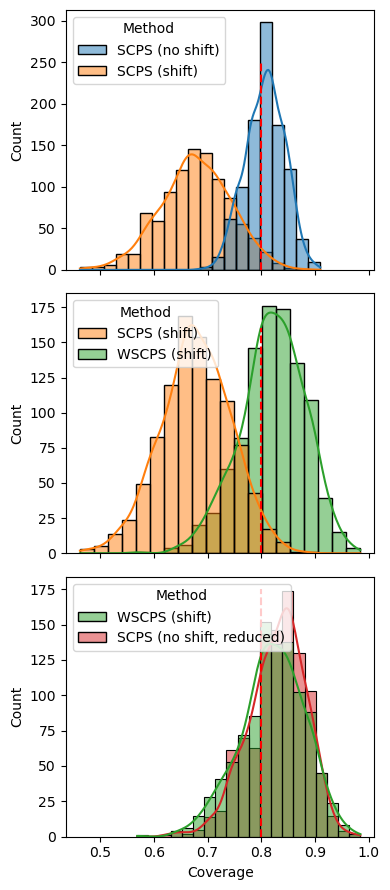

In [5]:
df_results_cps_no_shift['Method'] = 'SCPS (no shift)'
df_results_cps_shift_not_weighted['Method'] = 'SCPS (shift)'
df_results_cps_shift_weighted['Method'] = 'WSCPS (shift)'
df_results_cps_no_shift_reduced['Method'] = 'SCPS (no shift, reduced)'
df_results_cp_no_shift['Method'] = 'CP (no shift)'
df_results_cp_shift_not_weighted['Method'] = 'CP (shift)'
df_results_cp_shift_weighted['Method'] = 'WCP (shift)'
df_results_cp_no_shift_reduced['Method'] = 'CP (no shift, reduced)'

df_results = pd.concat([df_results_cps_no_shift, df_results_cps_shift_not_weighted, df_results_cps_shift_weighted,
                        df_results_cps_no_shift_reduced,
                        df_results_cp_no_shift, df_results_cp_shift_not_weighted, df_results_cp_shift_weighted,
                        df_results_cp_no_shift_reduced])

df_results["Coverage"] = 1 - df_results["error"]

fig, axs = plt.subplots(3, 1, figsize=(4, 9), sharex=True)
bins = 20
sns.histplot(data=df_results[df_results["Method"].isin(['SCPS (no shift)',
                                                        'SCPS (shift)'])]
             , x="Coverage", hue="Method", kde=True, ax=axs[0], bins=bins)
sns.move_legend(axs[0], "upper left")
# set the color palette
sns.histplot(data=df_results[df_results["Method"].isin(['WSCPS (shift)',
                                                        'SCPS (shift)'])]
             , x="Coverage", hue="Method", kde=True, ax=axs[1], bins=bins,
             palette=[sns.color_palette()[1], sns.color_palette()[2]])
sns.move_legend(axs[1], "upper left")
sns.histplot(data=df_results[df_results["Method"].isin(['WSCPS (shift)',
                                                        'SCPS (no shift, reduced)'])]
                , x="Coverage", hue="Method", kde=True, ax=axs[2], bins=bins,
                palette=[sns.color_palette()[2], sns.color_palette()[3]])
sns.move_legend(axs[2], "upper left")
axs[0].vlines(0.8, 0, 250, color='r', linestyle='--')
axs[1].vlines(0.8, 0, 160, color='r', linestyle='--')
axs[2].vlines(0.8, 0, 175, color='r', linestyle='--')
plt.tight_layout()
fig.savefig("plots/coverage_airfoil.pdf")
plt.show()

/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: Fut

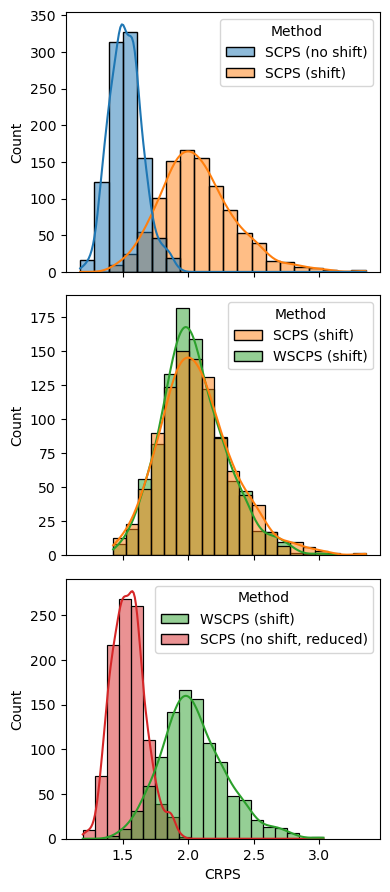

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(4, 9), sharex=True)
bins = 20
sns.histplot(data=df_results[df_results["Method"].isin(['SCPS (no shift)',
                                                        'SCPS (shift)'])]
             , x="CRPS", hue="Method", kde=True, ax=axs[0], bins=bins)
sns.move_legend(axs[0], "upper right")
# set the color palette
sns.histplot(data=df_results[df_results["Method"].isin(['WSCPS (shift)',
                                                        'SCPS (shift)'])]
             , x="CRPS", hue="Method", kde=True, ax=axs[1], bins=bins,
             palette=[sns.color_palette()[1], sns.color_palette()[2]])
sns.move_legend(axs[1], "upper right")
sns.histplot(data=df_results[df_results["Method"].isin(['WSCPS (shift)',
                                                        'SCPS (no shift, reduced)'])]
                , x="CRPS", hue="Method", kde=True, ax=axs[2], bins=bins,
                palette=[sns.color_palette()[2], sns.color_palette()[3]])
sns.move_legend(axs[2], "upper right")
plt.tight_layout()
fig.savefig("plots/crps_airfoil.pdf")
plt.show()

/opt/anaconda3/envs/uq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


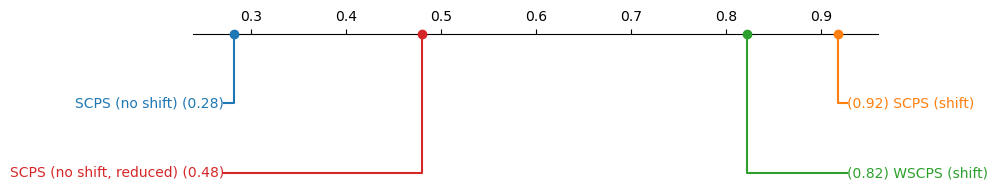

In [7]:
import scipy.stats as ss
import scikit_posthocs as sp

df_results_cps = df_results[df_results["Method"].isin(['SCPS (no shift)', 'SCPS (shift)', 'WSCPS (shift)', 'SCPS (no shift, reduced)'])]

avg_rank = df_results_cps.groupby("sim_id")["CRPS"].rank(pct=True).groupby(df_results_cps.Method).mean()

ss.friedmanchisquare(*[df_results_cps[df_results_cps.Method == method].CRPS for method in df_results_cps.Method.unique()])

test_results = sp.posthoc_nemenyi_friedman(df_results_cps, melted=True, y_col="CRPS", block_col="sim_id", group_col="Method")


plt.figure(figsize=(10, 2))
# plt.title("Post-hoc Friedman-Nemenyi test for CRPS")
sp.critical_difference_diagram(avg_rank, test_results, color_palette={"SCPS (no shift)": sns.color_palette()[0],
                                                                      "SCPS (shift)": sns.color_palette()[1],
                                                                      "WSCPS (shift)": sns.color_palette()[2],
                                                                      "SCPS (no shift, reduced)": sns.color_palette()[3]})
plt.tight_layout()
plt.savefig("plots/nemenyi_airfoil.pdf")
plt.show()

## Synthetic Dataset (Kang and Schafer (2007))
**Note: that this synthetic dataset is also used in Yang et al. 2022**

In [8]:
def synthetic_kang_schafer_2007(n=2000, weights=None):
    if weights is None:
        weights = np.ones(n)/n
    x1 = np.random.normal(size=n)
    x2 = np.random.normal(size=n)
    x3 = np.random.normal(size=n)
    x4 = np.random.normal(size=n)

    y = 210 + 27.4*x1 + 13.7*x2 + 13.7*x3 + 13.7*x4 + np.random.normal(size=n)

    return np.stack([x1, x2, x3, x4], axis=1), y

In [9]:
NSim = 1000
confidence = 0.8

for i in tqdm(range(NSim)):
    X, y = synthetic_kang_schafer_2007()
    # Without covariate-shift
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    X_train_prop, X_cal, y_train_prop, y_cal = train_test_split(X_train, y_train, test_size=0.5)

    shift_weights = np.array([-1, 0.5, -0.25, -0.1])
    shifted_likelihood_train_prop = np.exp(X_train_prop @ shift_weights)
    shifted_weights_train_prop = shifted_likelihood_train_prop / np.sum(shifted_likelihood_train_prop)
    shifted_likelihood_test = np.exp(X_test @ shift_weights)
    shifted_weights_test = shifted_likelihood_test / np.sum(shifted_likelihood_test)
    shifted_likelihood_cal =  np.exp(X_cal @ shift_weights)

    rf_cps = WrapRegressor(RandomForestRegressor(n_estimators=100, random_state=17))
    rf_cps.fit(X_train_prop, y_train_prop)
    rf_cp = copy.deepcopy(rf_cps)
    rf_cp.calibrate(X_cal, y_cal, cps=False)
    rf_cps.calibrate(X_cal, y_cal, cps=True)

    idx_no_shift = weighted_sample(np.ones(len(shifted_weights_test))/len(shifted_weights_test), frac=0.25)
    idx_shift = weighted_sample(shifted_weights_test, frac=0.25)

    n_reduced = np.sum(np.abs(shifted_likelihood_cal))**2 / np.sum(shifted_likelihood_cal**2)
    n = len(shifted_likelihood_cal)

    result_cps_no_shift = rf_cps.evaluate(X_test[idx_no_shift], y_test[idx_no_shift],
                                  confidence=confidence)
    result_cps_shift_not_weighted = rf_cps.evaluate(X_test[idx_shift], y_test[idx_shift],
                                            confidence=confidence)
    result_cp_no_shift = rf_cp.evaluate(X_test[idx_no_shift], y_test[idx_no_shift],
                                    confidence=confidence)
    result_cp_shift_not_weighted = rf_cp.evaluate(X_test[idx_shift], y_test[idx_shift],
                                              confidence=confidence)

    idx_cal_n_reduced = np.random.choice(range(n), size=int(n_reduced), replace=False)

    rf_cps_shift = copy.deepcopy(rf_cps)
    rf_cps_no_shift_reduced = copy.deepcopy(rf_cps)
    rf_cp_shift = copy.deepcopy(rf_cp)
    rf_cp_no_shift_reduced = copy.deepcopy(rf_cp)


    rf_cps_shift.calibrate(X_cal, y_cal, likelihood_ratios=shifted_likelihood_cal, cps=True)
    rf_cp_shift.calibrate(X_cal, y_cal, likelihood_ratios=shifted_likelihood_cal, cps=False)

    rf_cps_no_shift_reduced.calibrate(X_cal[idx_cal_n_reduced], y_cal[idx_cal_n_reduced], cps=True)
    rf_cp_no_shift_reduced.calibrate(X_cal[idx_cal_n_reduced], y_cal[idx_cal_n_reduced], cps=False)

    result_cps_shift_weighted = rf_cps_shift.evaluate(X_test[idx_shift], y_test[idx_shift],
                    likelihood_ratios=shifted_likelihood_test[idx_shift], confidence=confidence)
    result_cp_shift_weighted = rf_cp_shift.evaluate(X_test[idx_shift], y_test[idx_shift],
                    likelihood_ratios=shifted_likelihood_test[idx_shift], confidence=confidence)
    result_cps_no_shift_reduced = rf_cps_no_shift_reduced.evaluate(X_test[idx_no_shift], y_test[idx_no_shift],
                    confidence=confidence)
    result_cp_no_shift_reduced = rf_cp_no_shift_reduced.evaluate(X_test[idx_no_shift], y_test[idx_no_shift],
                    confidence=confidence)

    result_cps_shift_weighted["reduced_n"] = n_reduced
    result_cp_shift_weighted["reduced_n"] = n_reduced
    result_cps_no_shift_reduced["reduced_n"] = int(n_reduced)
    result_cp_no_shift_reduced["reduced_n"] = int(n_reduced)

    result_cps_no_shift["sim_id"] = i
    result_cps_shift_not_weighted["sim_id"] = i
    result_cps_shift_weighted["sim_id"] = i
    result_cp_no_shift["sim_id"] = i
    result_cp_shift_not_weighted["sim_id"] = i
    result_cp_shift_weighted["sim_id"] = i
    result_cps_no_shift_reduced["sim_id"] = i
    result_cp_no_shift_reduced["sim_id"] = i

    if i == 0:
        df_results_cps_no_shift_syn = pd.DataFrame(result_cps_no_shift, index=[0])
        df_results_cps_shift_not_weighted_syn = pd.DataFrame(result_cps_shift_not_weighted, index=[0])
        df_results_cps_shift_weighted_syn = pd.DataFrame(result_cps_shift_weighted, index=[0])
        df_results_cp_no_shift_syn = pd.DataFrame(result_cp_no_shift, index=[0])
        df_results_cp_shift_not_weighted_syn = pd.DataFrame(result_cp_shift_not_weighted, index=[0])
        df_results_cp_shift_weighted_syn = pd.DataFrame(result_cp_shift_weighted, index=[0])
        df_results_cps_no_shift_reduced_syn = pd.DataFrame(result_cps_no_shift_reduced, index=[0])
        df_results_cp_no_shift_reduced_syn = pd.DataFrame(result_cp_no_shift_reduced, index=[0])
    else:
        df_results_cps_no_shift_syn = pd.concat([df_results_cps_no_shift_syn, pd.DataFrame(result_cps_no_shift, index=[0])])
        df_results_cps_shift_not_weighted_syn = pd.concat([df_results_cps_shift_not_weighted_syn, pd.DataFrame(result_cps_shift_not_weighted, index=[0])])
        df_results_cps_shift_weighted_syn = pd.concat([df_results_cps_shift_weighted_syn, pd.DataFrame(result_cps_shift_weighted, index=[0])])
        df_results_cp_no_shift_syn = pd.concat([df_results_cp_no_shift_syn, pd.DataFrame(result_cp_no_shift, index=[0])])
        df_results_cp_shift_not_weighted_syn = pd.concat([df_results_cp_shift_not_weighted_syn, pd.DataFrame(result_cp_shift_not_weighted, index=[0])])
        df_results_cp_shift_weighted_syn = pd.concat([df_results_cp_shift_weighted_syn, pd.DataFrame(result_cp_shift_weighted, index=[0])])
        df_results_cps_no_shift_reduced_syn = pd.concat([df_results_cps_no_shift_reduced_syn, pd.DataFrame(result_cps_no_shift_reduced, index=[0])])
        df_results_cp_no_shift_reduced_syn = pd.concat([df_results_cp_no_shift_reduced_syn, pd.DataFrame(result_cp_no_shift_reduced, index=[0])])

  0%|          | 3/1000 [00:00<03:53,  4.27it/s]/Users/jefjonkers/Code/crepes-weighted/src/crepes_weighted/base.py:1195: UserWarning: the no. of calibration examples is too small for the following lower percentiles and observation: 
(Perc: 9.999999999999998, Obs: 3, Weight obs: [0.06045172], Smallest density: [0.10091071]) 
(Perc: 9.999999999999998, Obs: 8, Weight obs: [0.06045172], Smallest density: [0.10091071]) 
(Perc: 9.999999999999998, Obs: 56, Weight obs: [0.06045172], Smallest density: [0.10091071]) 
(Perc: 9.999999999999998, Obs: 84, Weight obs: [0.06045172], Smallest density: [0.10091071]) 
(Perc: 9.999999999999998, Obs: 140, Weight obs: [0.06045172], Smallest density: [0.10091071]) 
(Perc: 9.999999999999998, Obs: 200, Weight obs: [0.06045172], Smallest density: [0.10091071]) 
(Perc: 9.999999999999998, Obs: 202, Weight obs: [0.06045172], Smallest density: [0.10091071]); the corresponding values are set to y_min
  warnings.warn(
/Users/jefjonkers/Code/crepes-weighted/src/crepes

/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: Fut

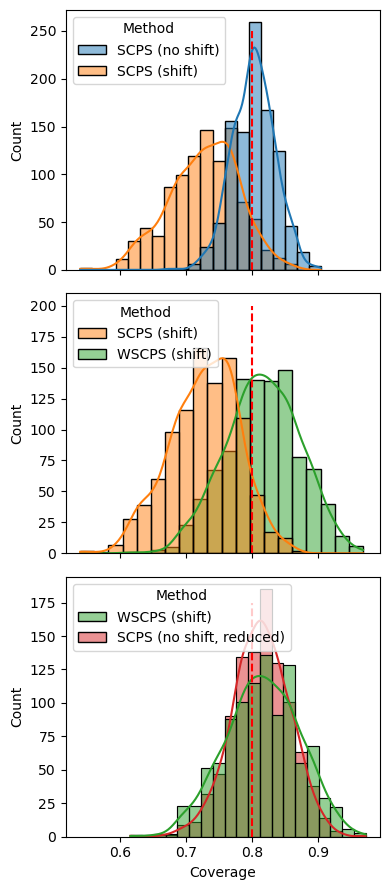

In [10]:
df_results_cps_no_shift_syn['Method'] = 'SCPS (no shift)'
df_results_cps_shift_not_weighted_syn['Method'] = 'SCPS (shift)'
df_results_cps_shift_weighted_syn['Method'] = 'WSCPS (shift)'
df_results_cps_no_shift_reduced_syn['Method'] = 'SCPS (no shift, reduced)'
df_results_cp_no_shift_syn['Method'] = 'CP (no shift)'
df_results_cp_shift_not_weighted_syn['Method'] = 'CP (shift)'
df_results_cp_shift_weighted_syn['Method'] = 'WCP (shift)'
df_results_cp_no_shift_reduced_syn['Method'] = 'CP (no shift, reduced)'

df_results_syn = pd.concat([df_results_cps_no_shift_syn, df_results_cps_shift_not_weighted_syn, df_results_cps_shift_weighted_syn,
                        df_results_cps_no_shift_reduced_syn,
                        df_results_cp_no_shift_syn, df_results_cp_shift_not_weighted_syn, df_results_cp_shift_weighted_syn,
                        df_results_cp_no_shift_reduced_syn])

df_results_syn["Coverage"] = 1 - df_results_syn["error"]

fig, axs = plt.subplots(3, 1, figsize=(4, 9), sharex=True)
bins = 20
sns.histplot(data=df_results_syn[df_results_syn["Method"].isin(['SCPS (no shift)',
                                                        'SCPS (shift)'])]
             , x="Coverage", hue="Method", kde=True, ax=axs[0], bins=bins)
sns.move_legend(axs[0], "upper left")
# set the color palette
sns.histplot(data=df_results_syn[df_results_syn["Method"].isin(['WSCPS (shift)',
                                                        'SCPS (shift)'])]
             , x="Coverage", hue="Method", kde=True, ax=axs[1], bins=bins,
             palette=[sns.color_palette()[1], sns.color_palette()[2]])
sns.move_legend(axs[1], "upper left")
sns.histplot(data=df_results_syn[df_results_syn["Method"].isin(['WSCPS (shift)',
                                                        'SCPS (no shift, reduced)'])]
                , x="Coverage", hue="Method", kde=True, ax=axs[2], bins=bins,
                palette=[sns.color_palette()[2], sns.color_palette()[3]])
sns.move_legend(axs[2], "upper left")
axs[0].vlines(0.8, 0, 250, color='r', linestyle='--')
axs[1].vlines(0.8, 0, 200, color='r', linestyle='--')
axs[2].vlines(0.8, 0, 175, color='r', linestyle='--')
plt.tight_layout()
plt.savefig("plots/coverage_synthetic.pdf")
plt.show()

/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: Fut

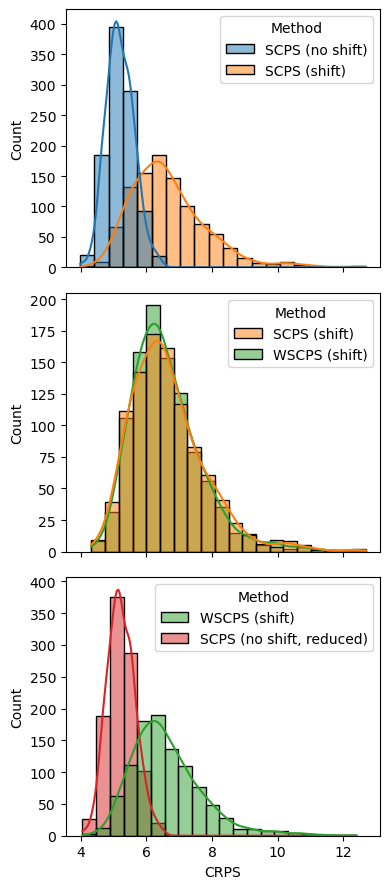

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(4, 9), sharex=True)
bins = 20
sns.histplot(data=df_results_syn[df_results_syn["Method"].isin(['SCPS (no shift)',
                                                        'SCPS (shift)'])]
             , x="CRPS", hue="Method", kde=True, ax=axs[0], bins=bins)
sns.move_legend(axs[0], "upper right")
# set the color palette
sns.histplot(data=df_results_syn[df_results_syn["Method"].isin(['WSCPS (shift)',
                                                        'SCPS (shift)'])]
             , x="CRPS", hue="Method", kde=True, ax=axs[1], bins=bins,
             palette=[sns.color_palette()[1], sns.color_palette()[2]])
sns.move_legend(axs[1], "upper right")
sns.histplot(data=df_results_syn[df_results_syn["Method"].isin(['WSCPS (shift)',
                                                        'SCPS (no shift, reduced)'])]
                , x="CRPS", hue="Method", kde=True, ax=axs[2], bins=bins,
                palette=[sns.color_palette()[2], sns.color_palette()[3]])
sns.move_legend(axs[2], "upper right")
plt.tight_layout()
fig.savefig("plots/crps_synthetic.pdf")
plt.show()

/opt/anaconda3/envs/uq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


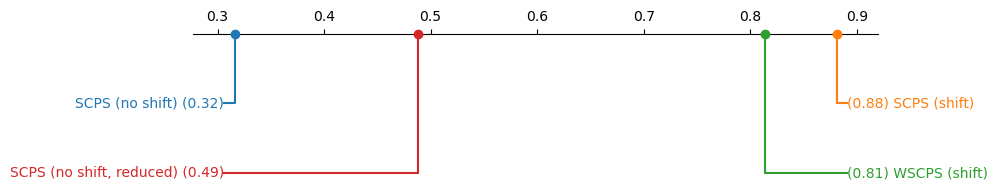

In [12]:
import scipy.stats as ss
import scikit_posthocs as sp

df_results_cps = df_results_syn[df_results_syn["Method"].isin(['SCPS (no shift)', 'SCPS (shift)', 'WSCPS (shift)', 'SCPS (no shift, reduced)'])]

avg_rank = df_results_cps.groupby("sim_id")["CRPS"].rank(pct=True).groupby(df_results_cps.Method).mean()

ss.friedmanchisquare(*[df_results_cps[df_results_cps.Method == method].CRPS for method in df_results_cps.Method.unique()])

test_results = sp.posthoc_nemenyi_friedman(df_results_cps, melted=True, y_col="CRPS", block_col="sim_id", group_col="Method")

plt.figure(figsize=(10, 2))
# plt.title("Post-hoc Friedman-Nemenyi test for CRPS")
sp.critical_difference_diagram(avg_rank, test_results, color_palette={"SCPS (no shift)": sns.color_palette()[0],
                                                                      "SCPS (shift)": sns.color_palette()[1],
                                                                      "WSCPS (shift)": sns.color_palette()[2],
                                                                      "SCPS (no shift, reduced)": sns.color_palette()[3]})
plt.tight_layout()
plt.savefig("plots/nemenyi_synthetic.pdf")
plt.show()

In [13]:
quantile_names = [f"coverage_q{q}" for q in np.arange(10, 100, 10)]

# Plot calibration curves
df_results_cps = df_results_syn[df_results_syn["Method"].isin(['SCPS (no shift)', 'SCPS (shift)', 'WSCPS (shift)', 'SCPS (no shift, reduced)'])]

## melt the data
df_results_cps_melted = pd.melt(df_results_cps, id_vars=["sim_id", "Method"], value_vars=quantile_names, value_name="Error", var_name="Quantile")
df_results_cps_melted["Quantile"] = df_results_cps_melted["Quantile"].str.replace("coverage_q", "").astype(int)

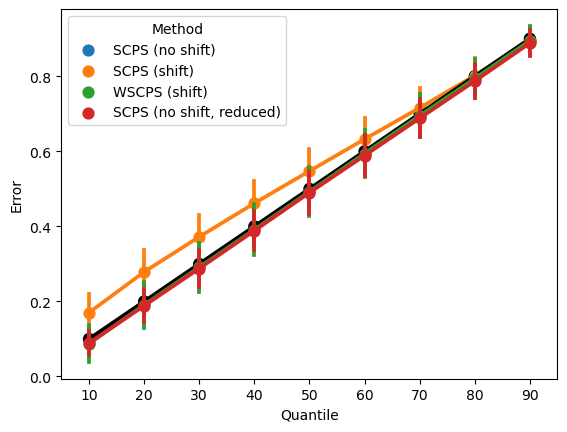

In [14]:
sns.pointplot(data=df_results_cps_melted, x="Quantile", y="Error", hue="Method", errorbar="sd")
sns.pointplot(y=np.arange(0.1, 1, 0.1), x=np.arange(10, 100, 10), color='black')
plt.savefig("plots/marginal_calibration_synthetic.pdf")

In [15]:
NSim = 1000

list_p_values_cps = []
list_p_values_wcps = []
list_p_values_cps_no_shift = []
for i in tqdm(range(NSim)):
    X, y = synthetic_kang_schafer_2007()
    # Without covariate-shift
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    X_train_prop, X_cal, y_train_prop, y_cal = train_test_split(X_train, y_train, test_size=0.25)

    shift_weights = np.array([-1, 0.5, -0.25, -0.1])
    shifted_likelihood_train_prop = np.exp(X_train_prop @ shift_weights)
    shifted_weights_train_prop = shifted_likelihood_train_prop / np.sum(shifted_likelihood_train_prop)
    shifted_likelihood_test = np.exp(X_test @ shift_weights)
    shifted_weights_test = shifted_likelihood_test / np.sum(shifted_likelihood_test)
    shifted_likelihood_cal =  np.exp(X_cal @ shift_weights)

    rf_cps = WrapRegressor(RandomForestRegressor(n_estimators=100, random_state=17))
    rf_cps.fit(X_train_prop, y_train_prop)
    rf_wcps = copy.deepcopy(rf_cps)


    idx_shift = weighted_sample(shifted_weights_test, frac=0.5)
    idx_no_shift = weighted_sample(np.ones(len(y_test))/ len(y_test), frac=0.5)

    rf_cps.calibrate(X_cal, y_cal, cps=True)
    rf_wcps.calibrate(X_cal, y_cal, likelihood_ratios=shifted_likelihood_cal, cps=True)

    p_values_cps = rf_cps.predict_cps(X_test[idx_shift], y=y_test[idx_shift])
    p_values_cps_no_shift = rf_cps.predict_cps(X_test[idx_no_shift], y=y_test[idx_no_shift])
    p_values_wcps = rf_wcps.predict_cps(X_test[idx_shift], y=y_test[idx_shift], likelihood_ratios=shifted_likelihood_test[idx_shift])

    list_p_values_cps.append(p_values_cps)
    list_p_values_cps_no_shift.append(p_values_cps_no_shift)
    list_p_values_wcps.append(p_values_wcps)

100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/uq/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


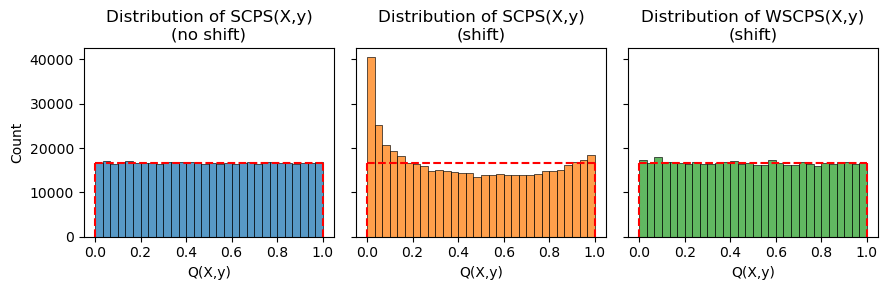

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
bins = 30
sns.histplot(np.concatenate(list_p_values_cps_no_shift), ax = axs[0], bins=bins,
             color=sns.color_palette()[0], label="CPS (no shift)")
sns.histplot(np.concatenate(list_p_values_cps), ax = axs[1], bins=bins,
             color=sns.color_palette()[1], label="CPS (shift)")
sns.histplot(np.concatenate(list_p_values_wcps), ax = axs[2], bins=bins,
             color=sns.color_palette()[2], label="WCPS (shift)")


axs[0].hlines(len(np.concatenate(list_p_values_cps_no_shift)) / bins, 0, 1, color='r', linestyle='--')
axs[1].hlines(len(np.concatenate(list_p_values_cps)) / bins, 0, 1, color='r', linestyle='--')
axs[2].hlines(len(np.concatenate(list_p_values_wcps)) / bins, 0, 1, color='r', linestyle='--')

axs[0].vlines(0, 0, len(np.concatenate(list_p_values_cps_no_shift)) / bins, color='r', linestyle='--')
axs[1].vlines(0, 0, len(np.concatenate(list_p_values_cps)) / bins, color='r', linestyle='--')
axs[2].vlines(0, 0, len(np.concatenate(list_p_values_wcps)) / bins, color='r', linestyle='--')

axs[0].vlines(1, 0, len(np.concatenate(list_p_values_cps_no_shift)) / bins, color='r', linestyle='--')
axs[1].vlines(1, 0, len(np.concatenate(list_p_values_cps)) / bins, color='r', linestyle='--')
axs[2].vlines(1, 0, len(np.concatenate(list_p_values_wcps)) / bins, color='r', linestyle='--')

axs[0].set_title("Distribution of SCPS(X,y)\n(no shift)")
axs[1].set_title("Distribution of SCPS(X,y)\n(shift)")
axs[2].set_title("Distribution of WSCPS(X,y)\n(shift)")

axs[0].set_xlabel("Q(X,y)")
axs[1].set_xlabel("Q(X,y)")
axs[2].set_xlabel("Q(X,y)")

plt.tight_layout()
fig.savefig("plots/prob_calibration_synthetic.pdf")
plt.show()